# 1. Work with Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import shap
import lime

In [2]:
# load the dataset
diabetes_data = pd.read_csv("./diabetes.csv")

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = diabetes_data[columns]
features = data.columns.drop('Outcome')

## EDA

### Corelation

In [3]:
correlation_matrix = data.corr()

# absolute correlation values (+ or -)
top_correlations = (correlation_matrix
                    .unstack()
                    .sort_values(ascending=False)
                    .drop_duplicates()
                    .reset_index()
                    .rename(columns={0: 'Correlation'})
                    .query('level_0 != level_1'))  # exclude self-correlations

print("Top Correlations:")
print(top_correlations.head(5))

Top Correlations:
       level_0        level_1  Correlation
1  Pregnancies            Age     0.544341
2      Glucose        Outcome     0.466581
3      Insulin  SkinThickness     0.436783
4          BMI  SkinThickness     0.392573
5      Glucose        Insulin     0.331357


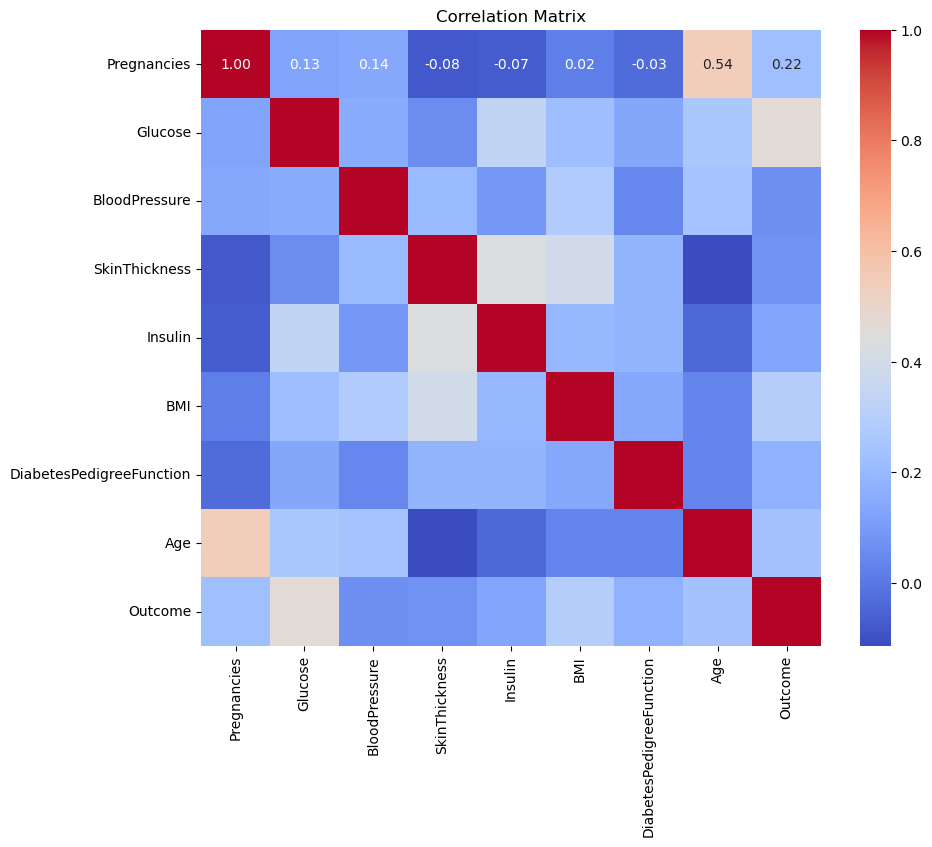

In [4]:
# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/homemac/miniconda3/envs/test/lib/py

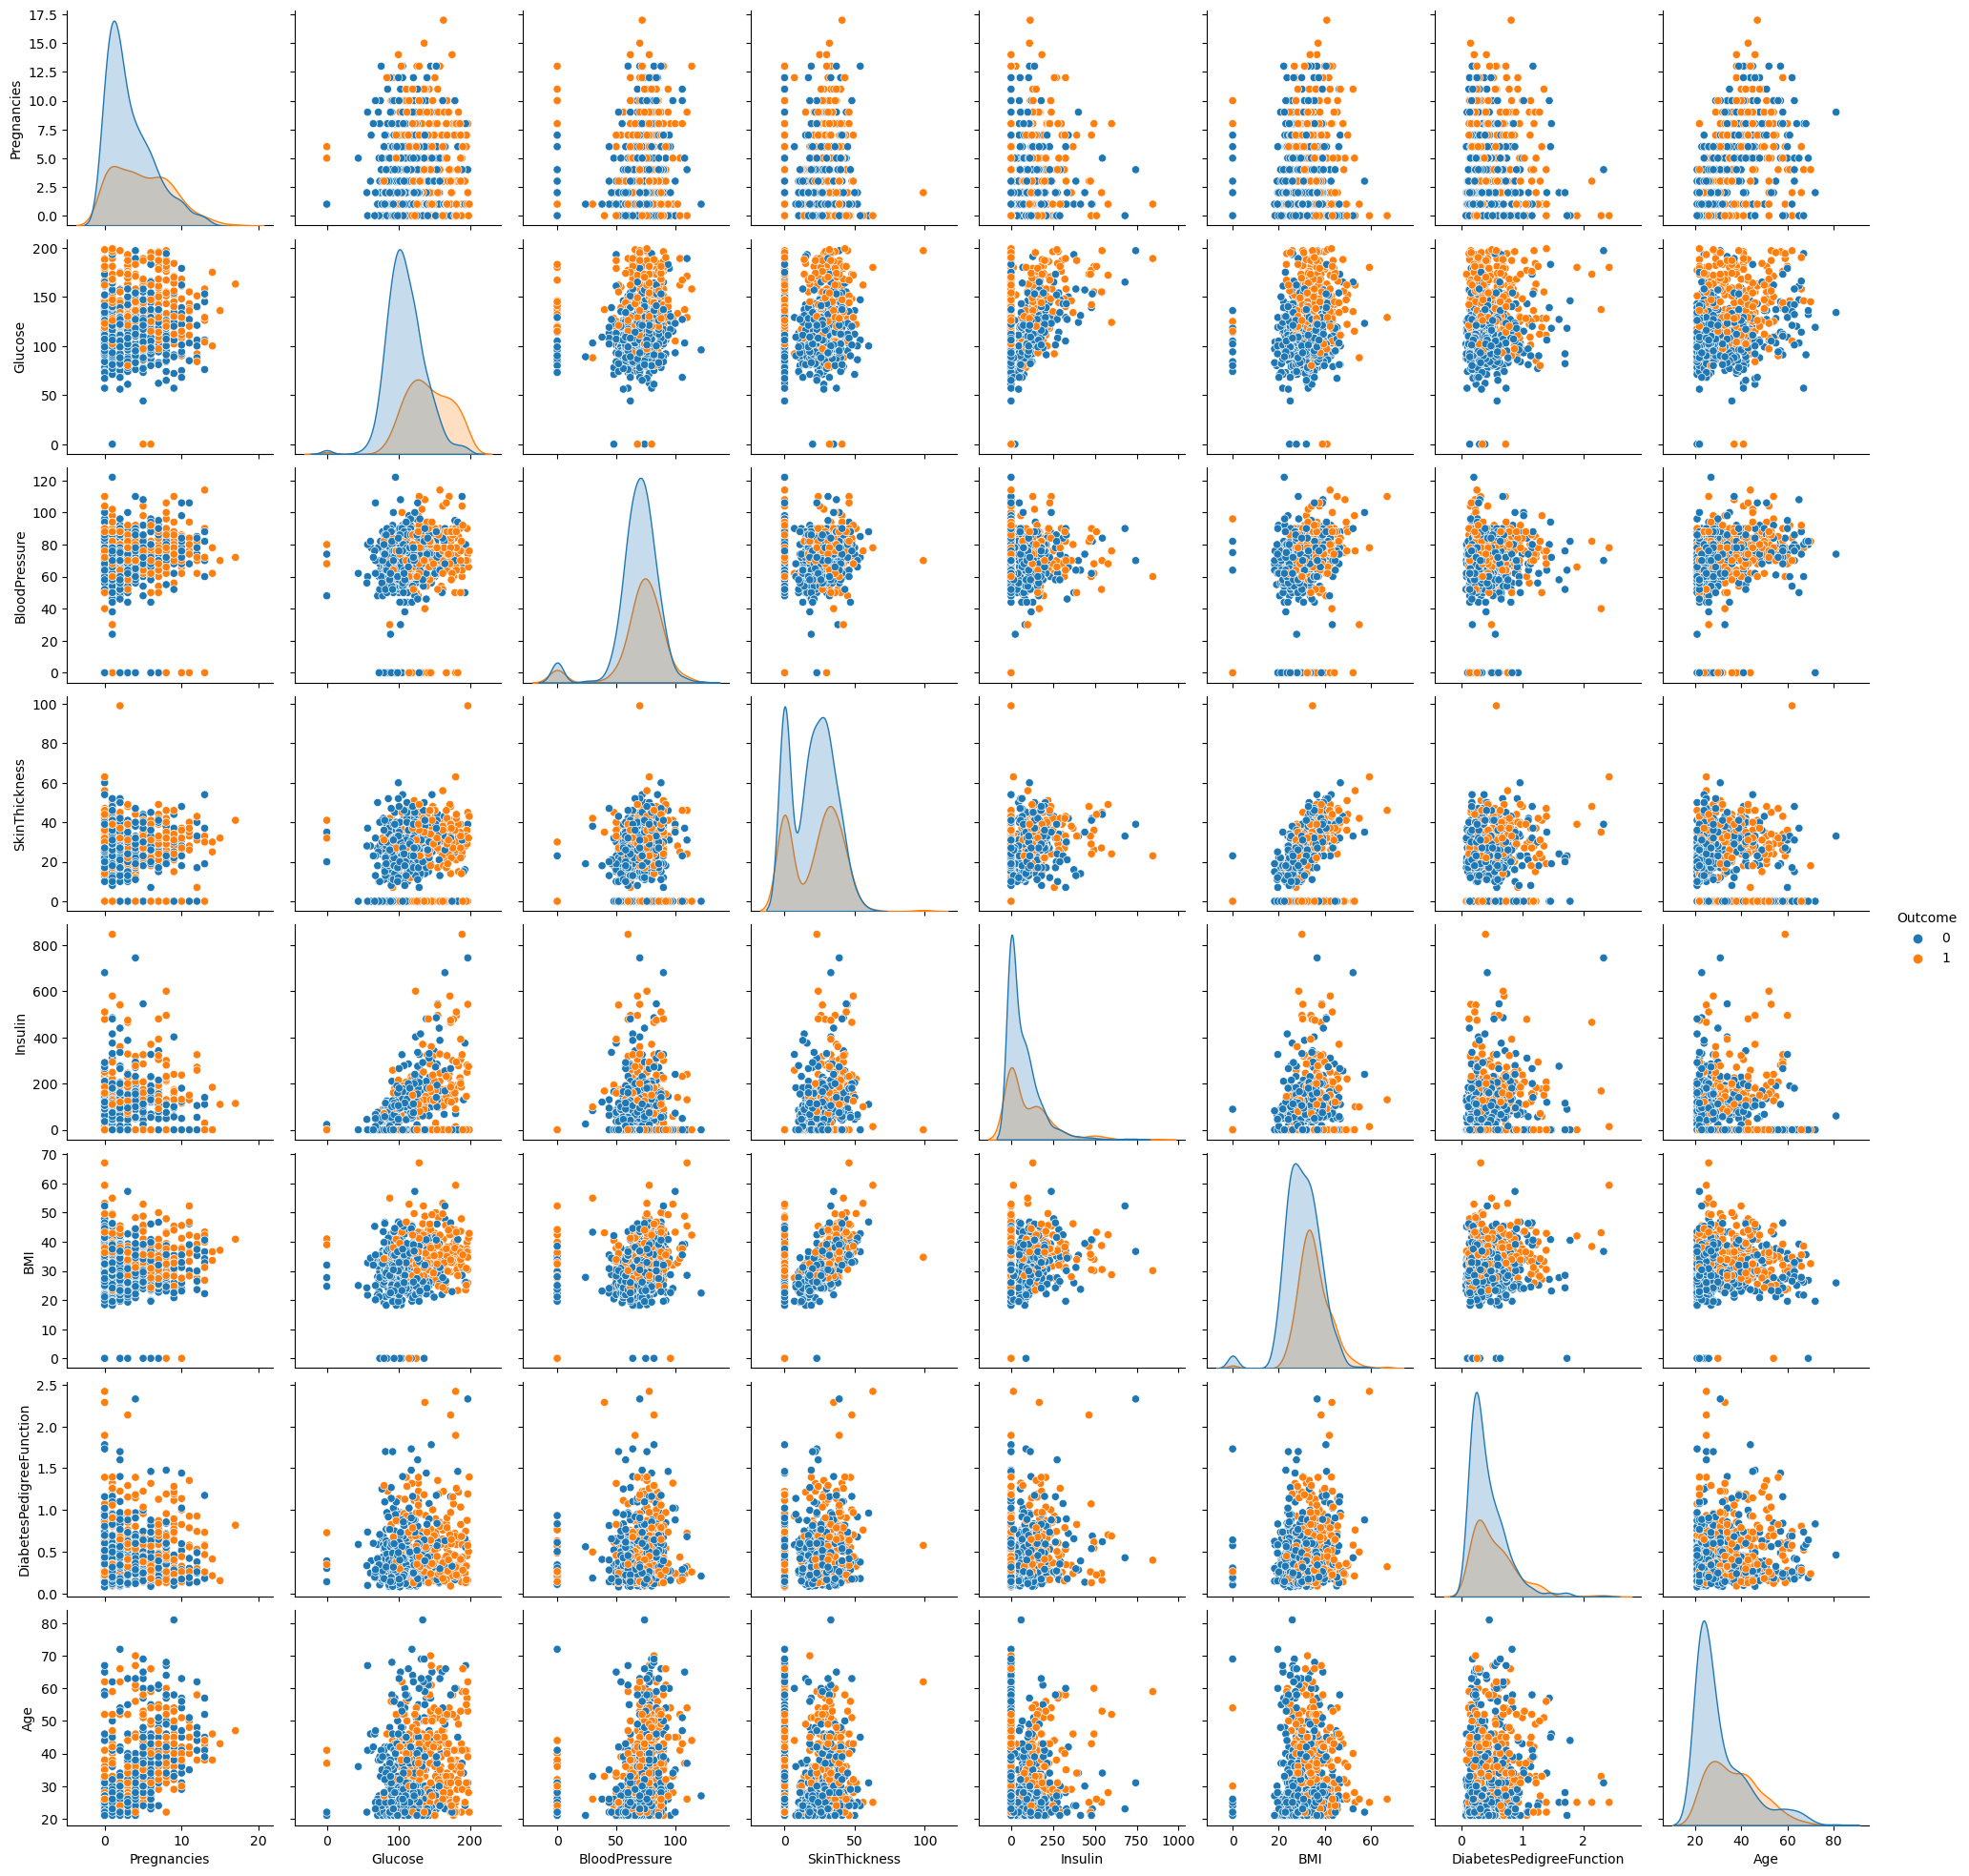

In [5]:
# Plot pairwise relationships with hue based on 'Outcome' column
sns.pairplot(data, hue='Outcome')
plt.show()

### Distribution

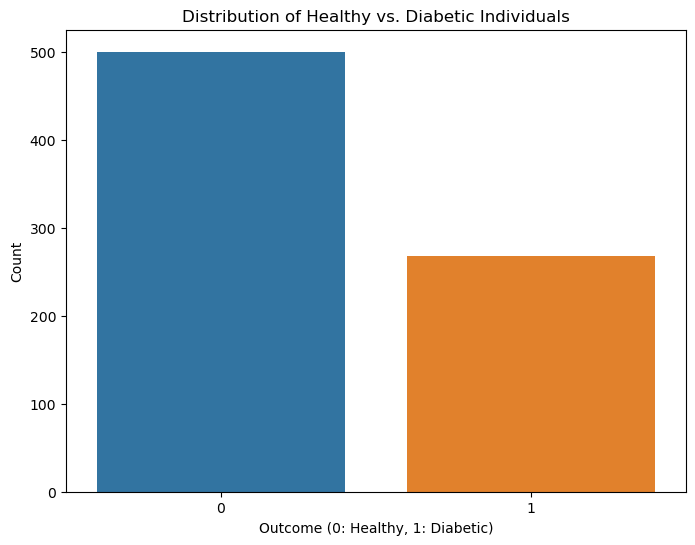

In [6]:
# healthy (Outcome=0) and diabetic (Outcome=1) individuals
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=data)
plt.title('Distribution of Healthy vs. Diabetic Individuals')
plt.xlabel('Outcome (0: Healthy, 1: Diabetic)')
plt.ylabel('Count')
plt.show()

In [7]:
# balance of available data
outcome_counts = data['Outcome'].value_counts()
balance_ratio = outcome_counts[0] / outcome_counts[1]

print("Number of Healthy Individuals (Outcome=0):", outcome_counts[0])
print("Number of Diabetic Individuals (Outcome=1):", outcome_counts[1])
print("Healthy to Diabetic Ratio: {:.2f}".format(balance_ratio))

Number of Healthy Individuals (Outcome=0): 500
Number of Diabetic Individuals (Outcome=1): 268
Healthy to Diabetic Ratio: 1.87


### Outliers

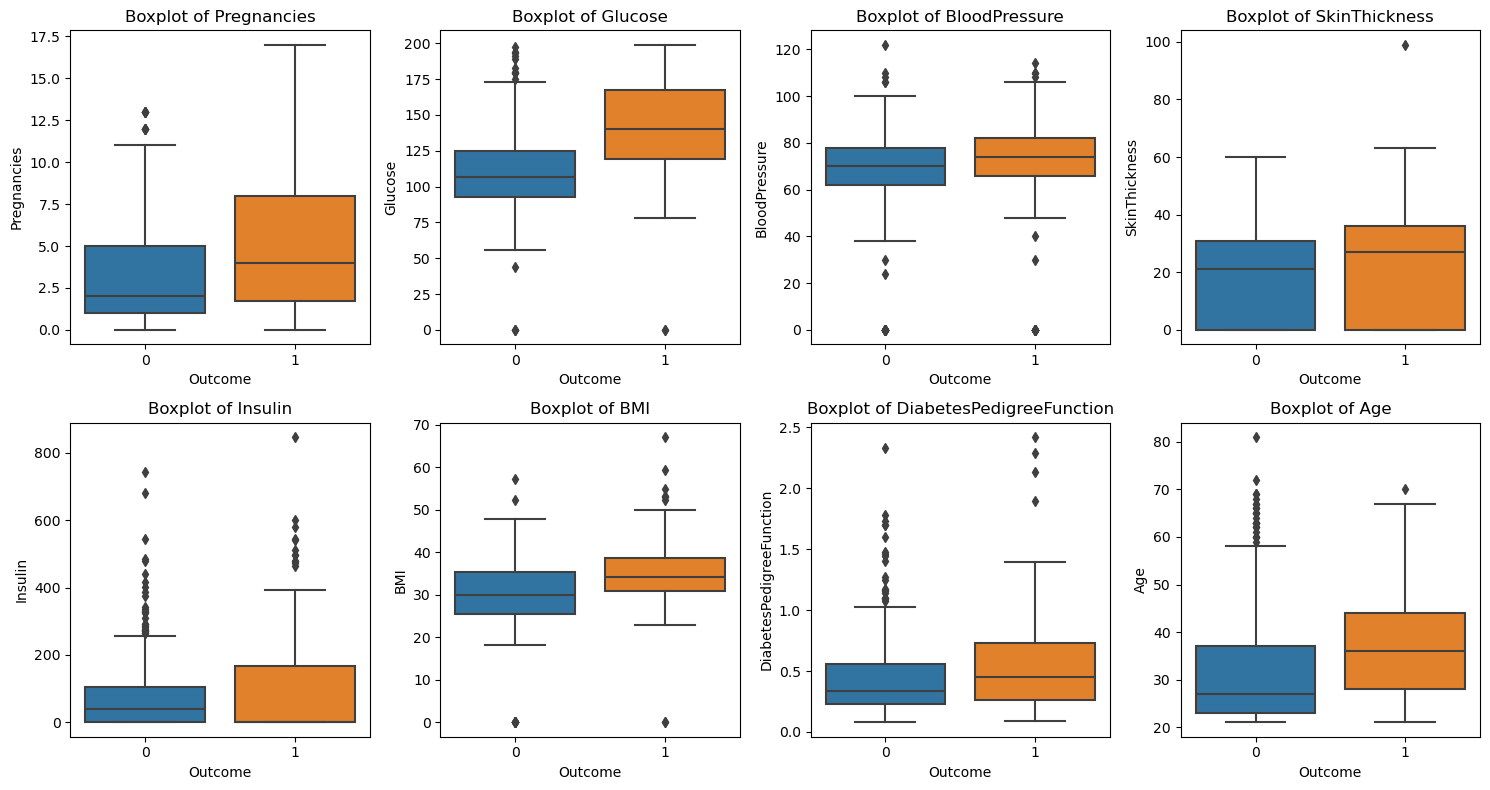

In [8]:
# boxplots for each column
plt.figure(figsize=(15, 8))
for i, column in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='Outcome', y=column, data=diabetes_data)
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


In [9]:
# dictionary to store the count of outliers for each column
outlier_counts = {}

for column in features:
    # IQR
    Q1 = diabetes_data[column].quantile(0.25)
    Q3 = diabetes_data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # upper and lower bounds for outliers
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    # Count outliers
    upper_outliers = (diabetes_data[column] > upper_bound).sum()
    lower_outliers = (diabetes_data[column] < lower_bound).sum()
    
    # total number of outliers
    total_outliers = upper_outliers + lower_outliers
    outlier_counts[column] = total_outliers

for column, count in outlier_counts.items():
    print(f"'{column}' has {count} outliers.")


'Pregnancies' has 4 outliers.
'Glucose' has 5 outliers.
'BloodPressure' has 45 outliers.
'SkinThickness' has 1 outliers.
'Insulin' has 34 outliers.
'BMI' has 19 outliers.
'DiabetesPedigreeFunction' has 29 outliers.
'Age' has 9 outliers.


### Normalization and Split Data

In [10]:
# normalize the data
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

In [11]:
# Split data into train+validation and test sets
train_val, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Outcome'])

# Split train+validation into train and validation sets
train, validation = train_test_split(train_val, test_size=0.125, random_state=42, stratify=train_val['Outcome'])  # 0.125 * 0.8 = 0.1

In [12]:
print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {validation.shape}")
print(f"Test set shape: {test.shape}")

print("\nDistribution of Outcome:")
print("Train:\n", train['Outcome'].value_counts(normalize=True))
print("Validation:\n", validation['Outcome'].value_counts(normalize=True))
print("Test:\n", test['Outcome'].value_counts(normalize=True))

Train set shape: (537, 9)
Validation set shape: (77, 9)
Test set shape: (154, 9)

Distribution of Outcome:
Train:
 Outcome
0    0.651769
1    0.348231
Name: proportion, dtype: float64
Validation:
 Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64
Test:
 Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


### Model

In [13]:
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layer1 = nn.Linear(8, 100)
        self.relu1 = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(100)
        self.layer2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.layer3 = nn.Linear(50, 50)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(50, 20)
        self.relu4 = nn.ReLU()
        self.layer5 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.batchnorm(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        x = self.relu4(x)
        x = self.layer5(x)
        # sigmoid activation
        return torch.sigmoid(x)

model = DiabetesModel()

### Train

In [14]:
X_train, y_train = torch.tensor(train[features].values).float(), torch.tensor(train['Outcome'].values).float()
X_val, y_val = torch.tensor(validation[features].values).float(), torch.tensor(validation['Outcome'].values).float()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    losses = []
    val_losses = []
    accuracies = []
    precisions = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        losses.append(average_loss)

        # validation
        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                all_preds.extend(predicted.numpy())
                all_labels.extend(labels.numpy())

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)
        
        accuracy = accuracy_score(all_labels, all_preds)
        accuracies.append(accuracy)
        
        precision = precision_score(all_labels, all_preds, zero_division=0)
        precisions.append(precision)
        
        print(f'Epoch {epoch+1}, Loss: {average_loss}, Val Loss: {average_val_loss}, Accuracy: {accuracy}, Precision: {precision}')

    # plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.plot(precisions, label='Precision')
    plt.title('Accuracy and Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

Epoch 1, Loss: 0.7034885322346407, Val Loss: 0.6774127086003622, Accuracy: 0.6233766233766234, Precision: 0.4782608695652174
Epoch 2, Loss: 0.5974635446772856, Val Loss: 0.5736602147420248, Accuracy: 0.8051948051948052, Precision: 0.75
Epoch 3, Loss: 0.4903881006381091, Val Loss: 0.5442233184973398, Accuracy: 0.7922077922077922, Precision: 0.72
Epoch 4, Loss: 0.4582880507497227, Val Loss: 0.5184447268644968, Accuracy: 0.8181818181818182, Precision: 0.76
Epoch 5, Loss: 0.429903787725112, Val Loss: 0.5194803675015768, Accuracy: 0.7792207792207793, Precision: 0.7083333333333334
Epoch 6, Loss: 0.415074365103946, Val Loss: 0.5257712602615356, Accuracy: 0.8181818181818182, Precision: 0.782608695652174
Epoch 7, Loss: 0.4137853874879725, Val Loss: 0.5270577470461527, Accuracy: 0.7922077922077922, Precision: 0.72
Epoch 8, Loss: 0.42548002565608306, Val Loss: 0.5818096101284027, Accuracy: 0.7922077922077922, Precision: 0.7619047619047619
Epoch 9, Loss: 0.40752648255404306, Val Loss: 0.5209504663

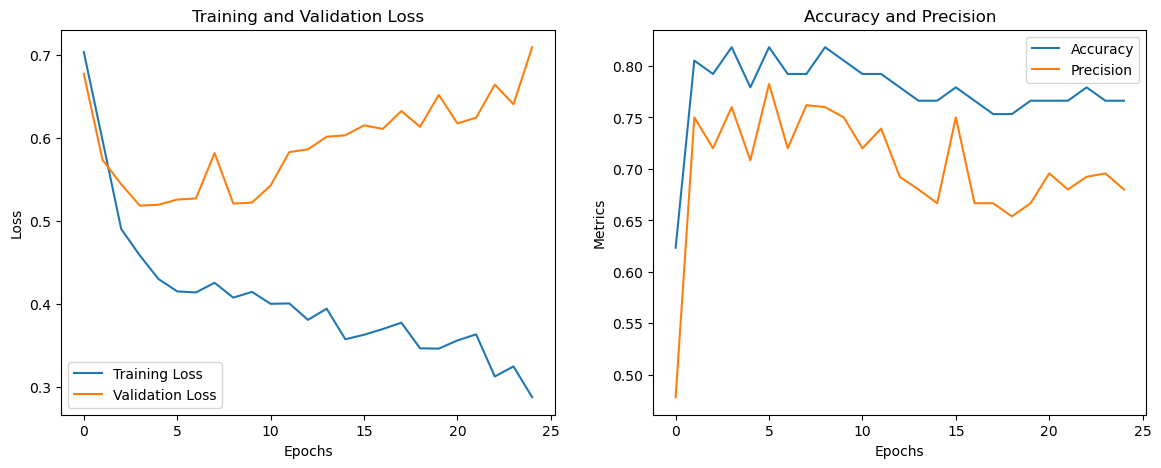

In [16]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

### Test

In [17]:
X_test, y_test = torch.tensor(test[features].values).float(), torch.tensor(test['Outcome'].values).float()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float().squeeze()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

evaluate_model(model, test_loader)

Precision: 0.6415094339622641
Recall: 0.6296296296296297
F1 Score: 0.6355140186915889
Confusion Matrix:
 [[81 19]
 [20 34]]


# 2. Interpret the model

## LIME

In [19]:
train_data_np = train[features].to_numpy()
train_labels_np = train['Outcome'].to_numpy()

In [20]:
lime_explainer = LimeTabularExplainer(
    training_data=train_data_np,
    feature_names=features,
    class_names=['Non-diabetic', 'Diabetic'],
    mode='classification'
)

In [21]:
def pytorch_predict_proba(data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).float()
        outputs = model(data_tensor)
        outputs = outputs.numpy()
        # probabilities for both classes
        return np.hstack((1-outputs, outputs))

In [22]:
# instances from test set
instances_to_explain = [0, 1, 2]

# explanations
for idx in instances_to_explain:
    instance = X_test[idx].numpy()
    explanation = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=pytorch_predict_proba,
        # number of features to display
        num_features=5
    )
    print(f'Explanation for instance {idx}:')
    explanation.show_in_notebook(show_table=True)

Explanation for instance 0:


Explanation for instance 1:


Explanation for instance 2:


## SHAP

In [23]:
def model_predict(data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).float()
        output = model(data_tensor)
        return output.numpy()

In [24]:
instances_to_explain = [0, 1, 2]
# first 100 instances for background
background = X_train[:100].numpy()

# SHAP explainer
shap_explainer = shap.KernelExplainer(model_predict, background)

# data instances based on the indices
instances_to_explain_data = X_test[instances_to_explain].numpy()

shap_values = shap_explainer.shap_values(instances_to_explain_data)

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
shap.initjs()

In [26]:
for idx, shap_value in enumerate(shap_values):
    print(f"Processing instance {idx}")
    
    # flatten the shap_value + only dealing with 1 instance
    if shap_value.ndim == 2 and shap_value.shape[1] == 1:
        # convert from (8, 1) to (8,)
        shap_value = shap_value.flatten()

    instance_features = instances_to_explain_data[idx]
    if instance_features.ndim == 1:
        instance_features = instance_features.reshape(1, -1)

    shap_plot = shap.force_plot(
        shap_explainer.expected_value, 
        shap_value, 
        features=instance_features, 
        feature_names=features
    )
    
    shap.save_html(f"shap_force_plot_instance_{idx}.html", shap_plot)
    display(shap_plot)

Processing instance 0


Processing instance 1


Processing instance 2


## Manual Comparison

In [27]:
def perturb_feature(instance, feature_index, new_value):
    perturbed_instance = instance.copy()
    perturbed_instance[feature_index] = new_value
    return perturbed_instance

def get_different_class_value(feature_index, instance_class):
    if instance_class == 0:
        different_class_data = train[(train['Outcome'] == 1)][features[feature_index]]
    else:
        different_class_data = train[(train['Outcome'] == 0)][features[feature_index]]
    
    return different_class_data.sample().values[0]

### 1st sample

In [28]:
# 1st instance to analyze
instance = X_test[instances_to_explain[0]].numpy()
instance_class = y_test[instances_to_explain[0]].numpy()

print(f"Original class: {instance_class}")
original_prediction = model_predict(instance.reshape(1, -1))[0]
print(f"Original prediction: {original_prediction}")

Original class: 0.0
Original prediction: [0.88152486]


In [29]:
# feature perturbation analysis
for feature_index in range(len(features)):
    new_value = get_different_class_value(feature_index, instance_class)
    perturbed_instance = perturb_feature(instance, feature_index, new_value)
    
    perturbed_prediction = model_predict(perturbed_instance.reshape(1, -1))[0]
    print(f"Perturbed prediction (feature {features[feature_index]}): {perturbed_prediction}")
    
    # difference in prediction
    prediction_diff = abs(original_prediction - perturbed_prediction)
    print(f"Prediction difference (feature {features[feature_index]}): {prediction_diff}")
    print()

Perturbed prediction (feature Pregnancies): [0.8773937]
Prediction difference (feature Pregnancies): [0.00413114]

Perturbed prediction (feature Glucose): [0.91647226]
Prediction difference (feature Glucose): [0.0349474]

Perturbed prediction (feature BloodPressure): [0.87397736]
Prediction difference (feature BloodPressure): [0.0075475]

Perturbed prediction (feature SkinThickness): [0.58257335]
Prediction difference (feature SkinThickness): [0.2989515]

Perturbed prediction (feature Insulin): [0.8932284]
Prediction difference (feature Insulin): [0.01170355]

Perturbed prediction (feature BMI): [0.88146627]
Prediction difference (feature BMI): [5.8591366e-05]

Perturbed prediction (feature DiabetesPedigreeFunction): [0.87573665]
Prediction difference (feature DiabetesPedigreeFunction): [0.00578821]

Perturbed prediction (feature Age): [0.85448635]
Prediction difference (feature Age): [0.02703851]



### 2nd sample

In [30]:
instance = X_test[instances_to_explain[1]].numpy()
instance_class = y_test[instances_to_explain[1]].numpy()

print(f"Original class: {instance_class}")
original_prediction = model_predict(instance.reshape(1, -1))[0]
print(f"Original prediction: {original_prediction}")

Original class: 0.0
Original prediction: [0.03114698]


In [31]:
for feature_index in range(len(features)):
    new_value = get_different_class_value(feature_index, instance_class)
    perturbed_instance = perturb_feature(instance, feature_index, new_value)
    
    perturbed_prediction = model_predict(perturbed_instance.reshape(1, -1))[0]
    print(f"Perturbed prediction (feature {features[feature_index]}): {perturbed_prediction}")
    
    # Calculate the difference in prediction
    prediction_diff = abs(original_prediction - perturbed_prediction)
    print(f"Prediction difference (feature {features[feature_index]}): {prediction_diff}")
    print()

Perturbed prediction (feature Pregnancies): [0.24831937]
Prediction difference (feature Pregnancies): [0.2171724]

Perturbed prediction (feature Glucose): [0.18013118]
Prediction difference (feature Glucose): [0.14898421]

Perturbed prediction (feature BloodPressure): [0.02692568]
Prediction difference (feature BloodPressure): [0.00422129]

Perturbed prediction (feature SkinThickness): [0.0506794]
Prediction difference (feature SkinThickness): [0.01953243]

Perturbed prediction (feature Insulin): [0.03447029]
Prediction difference (feature Insulin): [0.00332331]

Perturbed prediction (feature BMI): [0.02377602]
Prediction difference (feature BMI): [0.00737095]

Perturbed prediction (feature DiabetesPedigreeFunction): [0.03681821]
Prediction difference (feature DiabetesPedigreeFunction): [0.00567124]

Perturbed prediction (feature Age): [0.08669897]
Prediction difference (feature Age): [0.055552]



### 3rd sample

In [32]:
instance = X_test[instances_to_explain[2]].numpy()
instance_class = y_test[instances_to_explain[2]].numpy()

print(f"Original class: {instance_class}")
original_prediction = model_predict(instance.reshape(1, -1))[0]
print(f"Original prediction: {original_prediction}")

Original class: 0.0
Original prediction: [0.29250896]


In [33]:
for feature_index in range(len(features)):
    new_value = get_different_class_value(feature_index, instance_class)
    perturbed_instance = perturb_feature(instance, feature_index, new_value)
    
    perturbed_prediction = model_predict(perturbed_instance.reshape(1, -1))[0]
    print(f"Perturbed prediction (feature {features[feature_index]}): {perturbed_prediction}")
    
    prediction_diff = abs(original_prediction - perturbed_prediction)
    print(f"Prediction difference (feature {features[feature_index]}): {prediction_diff}")
    print()

Perturbed prediction (feature Pregnancies): [0.29250896]
Prediction difference (feature Pregnancies): [0.]

Perturbed prediction (feature Glucose): [0.6247426]
Prediction difference (feature Glucose): [0.33223367]

Perturbed prediction (feature BloodPressure): [0.28651586]
Prediction difference (feature BloodPressure): [0.0059931]

Perturbed prediction (feature SkinThickness): [0.006213]
Prediction difference (feature SkinThickness): [0.28629595]

Perturbed prediction (feature Insulin): [0.36742535]
Prediction difference (feature Insulin): [0.07491639]

Perturbed prediction (feature BMI): [0.25218278]
Prediction difference (feature BMI): [0.04032618]

Perturbed prediction (feature DiabetesPedigreeFunction): [0.26374885]
Prediction difference (feature DiabetesPedigreeFunction): [0.02876011]

Perturbed prediction (feature Age): [0.65160644]
Prediction difference (feature Age): [0.35909748]



## LIME & SHAP for the whole test data

### LIME

In [34]:
feature_weights = {f: 0.0 for f in features}

for idx in range(len(X_test)):
    explanation = lime_explainer.explain_instance(
        data_row=X_test[idx].numpy(),
        predict_fn=pytorch_predict_proba,
        num_features=len(features)
    )
    
    # Aggregate feature weights within the same loop
    exp_map = dict(explanation.as_list())
    for exp_feature, weight in exp_map.items():
        original_feature = exp_feature.split()[0]
        if original_feature in feature_weights:
            feature_weights[original_feature] += weight

In [35]:
num_instances = len(X_test)
for feature in feature_weights:
    if feature_weights[feature] != 0:
        feature_weights[feature] /= num_instances
    print(f"Average weight for {feature}: {feature_weights[feature]}")

Average weight for Pregnancies: 0.04022442722470195
Average weight for Glucose: 0.05272731055295529
Average weight for BloodPressure: -0.009677058542302433
Average weight for SkinThickness: -0.001485462715706858
Average weight for Insulin: 0.0019786797190635623
Average weight for BMI: -0.008210256289731627
Average weight for DiabetesPedigreeFunction: 0.004633293358630728
Average weight for Age: -0.007810055178710401


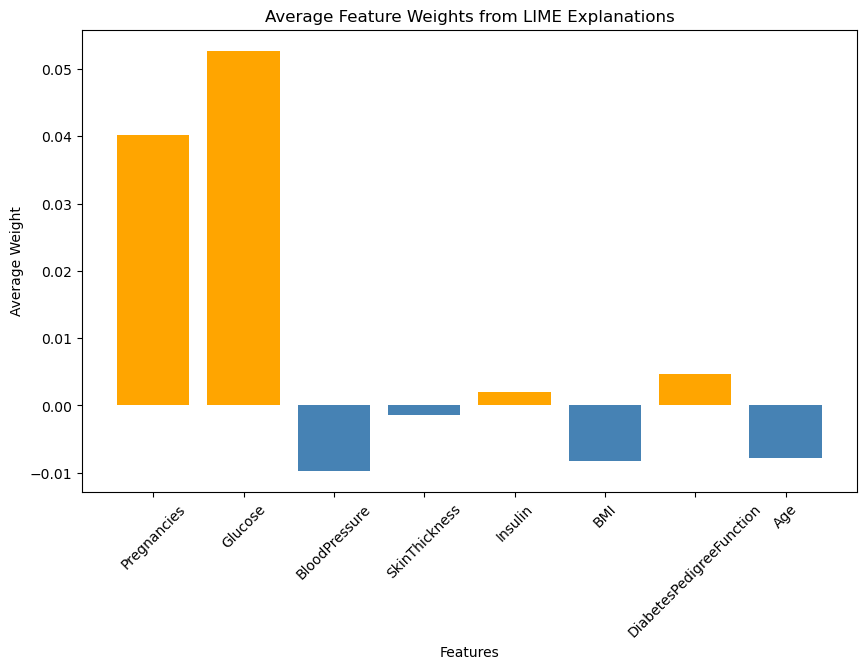

In [36]:
plt.figure(figsize=(10, 6))
colors = ['orange' if x >= 0 else 'steelblue' for x in feature_weights.values()]
plt.bar(features, feature_weights.values(), color=colors)
plt.xlabel('Features')
plt.ylabel('Average Weight')
plt.title('Average Feature Weights from LIME Explanations')
plt.xticks(rotation=45)
plt.show()

### SHAP

  0%|          | 0/154 [00:00<?, ?it/s]

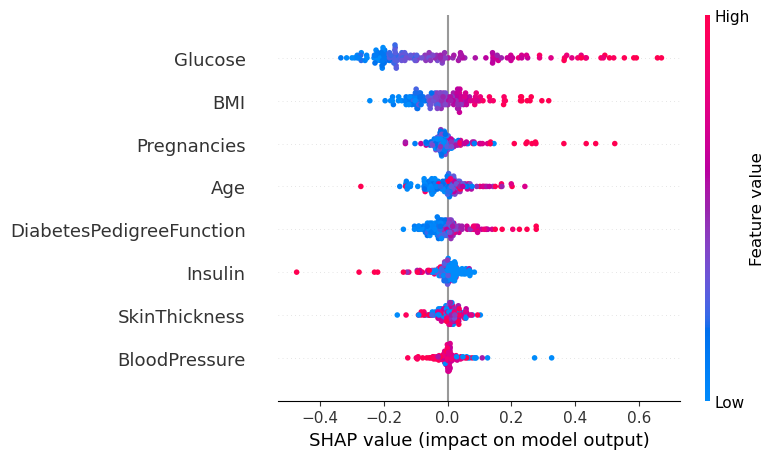

In [48]:
shap_values = shap_explainer.shap_values(X_test.numpy())
shap_values = shap_values.squeeze()

shap.summary_plot(shap_values, X_test.numpy(), feature_names=features.tolist())

In [53]:
mean_shap_values = np.mean(shap_values, axis=0)

shap_summary_df = pd.DataFrame({
    'Feature': features,
    'Mean SHAP Value': mean_shap_values
})

print(shap_summary_df)

                    Feature  Mean SHAP Value
0               Pregnancies         0.019237
1                   Glucose        -0.008976
2             BloodPressure         0.004966
3             SkinThickness         0.003741
4                   Insulin        -0.007160
5                       BMI        -0.004422
6  DiabetesPedigreeFunction         0.001769
7                       Age         0.000004


## NAM

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from nam.wrapper import NAMClassifier

# Load the dataset
diabetes_data = pd.read_csv("./diabetes.csv")

# Specify the feature columns and target column
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = diabetes_data[columns]
features = data.columns.drop('Outcome')
target = 'Outcome'
# normalize the data
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Split the dataset into features (X) and target (y)
X = data[features]
y = data[target]

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize the NAMClassifier
model = NAMClassifier(
    num_epochs=1000,
    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities on the test set
pred_proba = model.predict_proba(X_test)
print("Shape of predict_proba output:", pred_proba.shape)

# Use the predicted probabilities directly for ROC AUC score
roc_auc = roc_auc_score(y_test, pred_proba)
print("ROC AUC Score:", roc_auc)


Shape of predict_proba output: (116, 1)
ROC AUC Score: 0.8123606244026761


In [77]:
#@title Plotting Helper Functions

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, num_rows, num_cols, 
                            n_blocks=5, color=[0.9, 0.5, 0.5], 
                            feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
  max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 

  for i, (name, pred) in enumerate(hist_data_pairs):

    # unique_x_data, single_feature_data, pred = data
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
    ax = plt.subplot(num_rows, num_cols, i+1)
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    x_n_blocks = min(n_blocks, len(unique_x_data))
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    segments = (max_x - min_x) / x_n_blocks
    density = np.histogram(single_feature_data, bins=x_n_blocks)
    normed_density = density[0] / np.max(density[0])
    rect_params = []
    for p in range(x_n_blocks):
      start_x = min_x + segments * p
      end_x = min_x + segments * (p + 1)
      # start_insert_index = min(
      #     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
      # end_insert_index = min(
      #     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
      # d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
      d = min(1.0, 0.01 + normed_density[p])
      rect_params.append((d, start_x, end_x))

    for param in rect_params:
      alpha, start_x, end_x = param 
      rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x, 
                               max_y - min_y + 1, linewidth=0.01, 
                              edgecolor=color, facecolor=color, alpha=alpha)
      ax.add_patch(rect)


def plot_all_hist(hist_data, num_rows, num_cols,  color_base, 
                  linewidth=3.0, min_y=None, max_y=None, alpha=1.0, 
                  feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  if min_y is None:
    min_y = np.min([np.min(a) for _, a in hist_data_pairs])
  if max_y is None:
    max_y = np.max([np.max(a) for _, a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif
  col_mapping = COL_NAMES[dataset_name]
  feature_mapping = FEATURE_LABEL_MAPPING[dataset_name] 

  total_mean_bias = 0

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 
  
  for i, (name, pred) in enumerate(hist_data_pairs):
    mean_pred = MEAN_PRED[name] #np.mean(pred)
    total_mean_bias += mean_pred
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    plt.subplot(num_rows, num_cols, i+1)

    if name in CATEGORICAL_NAMES:
      unique_x_data = np.round(unique_x_data, decimals=1)
      if len(unique_x_data) <= 2:
        step_loc = "mid"
      else:
        step_loc = "post"
      unique_plot_data = np.array(unique_x_data) - 0.5
      unique_plot_data[-1] += 1
      plt.step(unique_plot_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, where=step_loc, alpha=alpha)

      if name in feature_mapping:
        labels, rot = feature_mapping[name]
      else:
        labels = unique_x_data
        rot = None
      plt.xticks(unique_x_data, labels=labels, fontsize='x-large', rotation=rot)
    else:
      plt.plot(unique_x_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, alpha=alpha)
      plt.xticks(fontsize='x-large')
  
   
    plt.ylim(min_y, max_y)
    plt.yticks(fontsize='x-large')
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    plt.xlim(min_x, max_x)
    if i % num_cols == 0:
      plt.ylabel('House Price Contribution', fontsize='x-large')
    plt.xlabel(col_mapping[name], fontsize='x-large')
  return min_y, max_y

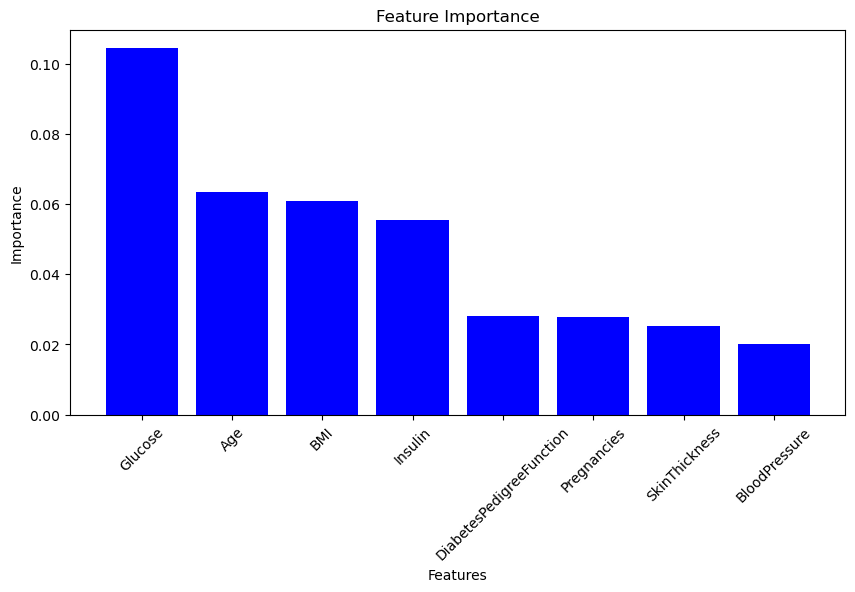

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone

# Assuming `model` is your trained NAMClassifier and `data` is your full dataset

def compute_feature_importances(model, data, features):
    original_preds = model.predict_proba(data)  # Get the original predictions
    importance_scores = {}
    
    for feature in features:
        temp_data = data.copy()
        # Set the feature to its mean value
        temp_data[feature] = data[feature].mean()
        modified_preds = model.predict_proba(temp_data)
        # Compute the change in predictions
        importance_scores[feature] = np.mean(np.abs(original_preds - modified_preds))
    
    return importance_scores

# Compute the feature importances
features = data.columns.drop('Outcome')
importance_scores = compute_feature_importances(model, data[features], features)

# Plotting
def plot_importances(importance_scores):
    # Sort features by importance
    sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*sorted_features)
    
    plt.figure(figsize=(10, 5))
    plt.bar(features, scores, color='blue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=45)
    plt.show()

plot_importances(importance_scores)